## MODELOS AVANZADOS DE ANALISIS DE DATOS
### P1 ###


## GRUPO 2: ##
Marta Pizarro       202027959

Diego Quevedo       200914623

Alfredo Hincapié    199817792

Guillermo Andrade   202027949

Elber Pardo         200017815


### Introducción
Seleccionamos la base de datos de homicidios en Bogotá, correspondiente al período enero 1 de 2010 a junio 30 de 2021; se considera que esta información es relevante, debido a que es un indicador que permite vislumbrar la calidad de vida en una ciudad y contribuye a la generación de inversiones para la ciudad.

El establecimiento de un modelo que permita predecir el comportamiento futuro de los homicidios, constituirá una herramienta que puedan utilizar los alcaldes para fijar estrategias de inversión social y planes de seguridad en conjunto con la Policía y la Fiscalía, de manera tal que incidan en la disminución del índice de homicidios en nuestra ciudad.

Los datos son agregados de los homicidios sin distinción de sexo, edades, armas utilizadas, localidades, etc.


In [141]:
import warnings; 
warnings.simplefilter('ignore')

In [61]:
#Cargar librerías

import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 9
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from pandas.plotting import register_matplotlib_converters
import random 
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy as sp
import scipy.stats
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
register_matplotlib_converters()
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
#from plotly import plot_mpl

In [47]:
%matplotlib inline
sns.set()

In [48]:
#Importación de los datos
data = pd.ExcelFile('C:/Users/pcmgmt/Documents/MODELOS AVANZADOS1_2021/TAREAS/Homicid1.xlsx')
print(data.sheet_names)#revisar datos
#Data Frame de la hoja "Datos"
df=data.parse('Hoja1')#seleccionar una hoja específica
df.head()#revisar primeros filas del dataset

['Hoja1']


,Fecha,Cant
0,2010-01-01,16
1,2010-01-02,2
2,2010-01-03,1
3,2010-01-05,5
4,2010-01-06,2


In [49]:
df.describe() #análisis rápido de los datos

,Cant
count,3927.000000
mean,3.634836
std,2.462679
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,25.000000


In [50]:
# Verificar missing values
df.isna().sum()


Fecha    0
Cant     0
dtype: int64

In [51]:
# Detectar valores atípicos -outliers: 
df[df['Cant'].isin([np.nan, np.inf, -np.inf])]

,Fecha,Cant


In [54]:
type(df)

pandas.core.frame.DataFrame

In [53]:
df.Fecha=pd.to_datetime(df.Fecha)###dejar la serie en formato de fecha, (columna Fecha)
df.Fecha
type (df.Fecha)

pandas.core.series.Series

Text(0.5, 1.0, 'Homicidios diarios en Bogotá 2010-2021')

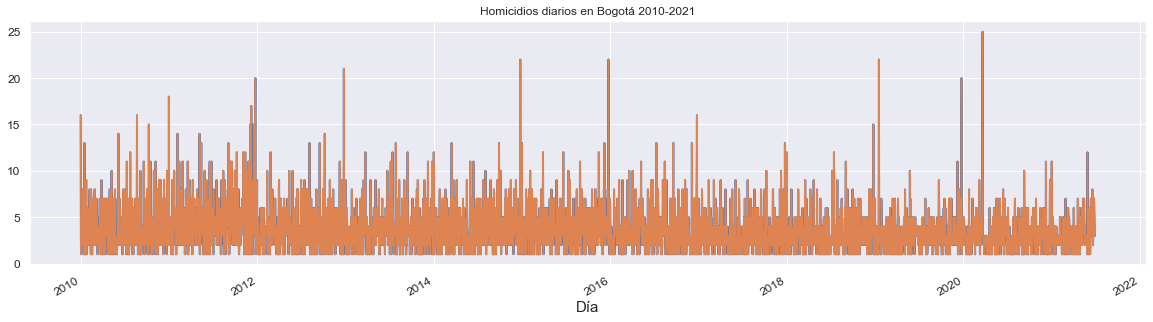

In [62]:
#Al graficar la serie diaria no se ve claramente una tendencia o estacionalidad por su alto volumen de datos.
trend=df.set_index('Fecha')#indica que la serie es mensual
tstrend=trend['Cant']##Convertir en serie de tiempo
tstrend.plot(figsize=(20,5), linewidth=2, fontsize=12)
plt.xlabel('Día', fontsize=15);

plt.plot(tstrend)
plt.title('Homicidios diarios en Bogotá 2010-2021')

Fecha
2010-01-31    112
2010-02-28    102
2010-03-31    107
2010-04-30     95
2010-05-31     99
Freq: M, Name: Cant, dtype: int64


Text(0.5, 1.0, 'Homicidios mensuales en Bogotá 2010-2021')

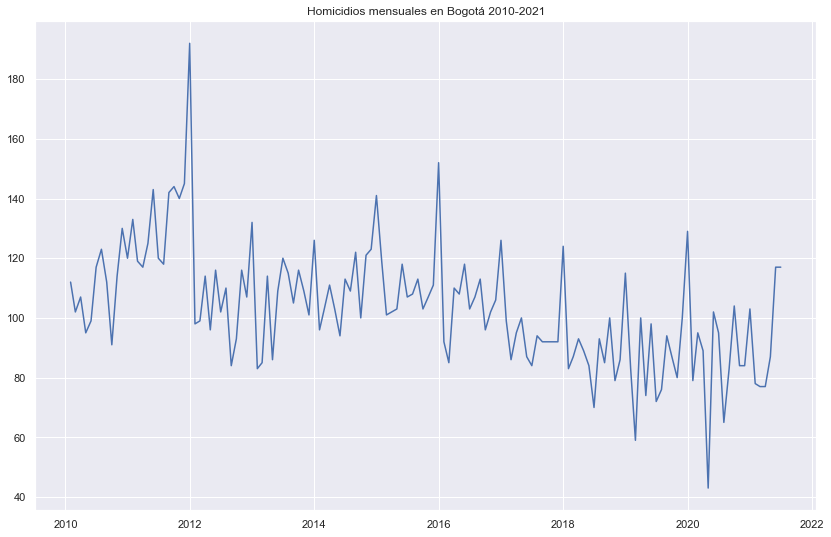

In [63]:
#Convertimos la serie diaria a mensual, sumando los datos diarios y almacenándolos de forma mensual.  La gráfica se ve mucho mejor
resample = tstrend.resample('M')
tstrend = resample.sum()
print(tstrend.head())
plt.plot(tstrend)
plt.title('Homicidios mensuales en Bogotá 2010-2021')


In [58]:
tstrend.isna().sum()#Revisar que se generaron "missing values"; se aprecia que NO

0

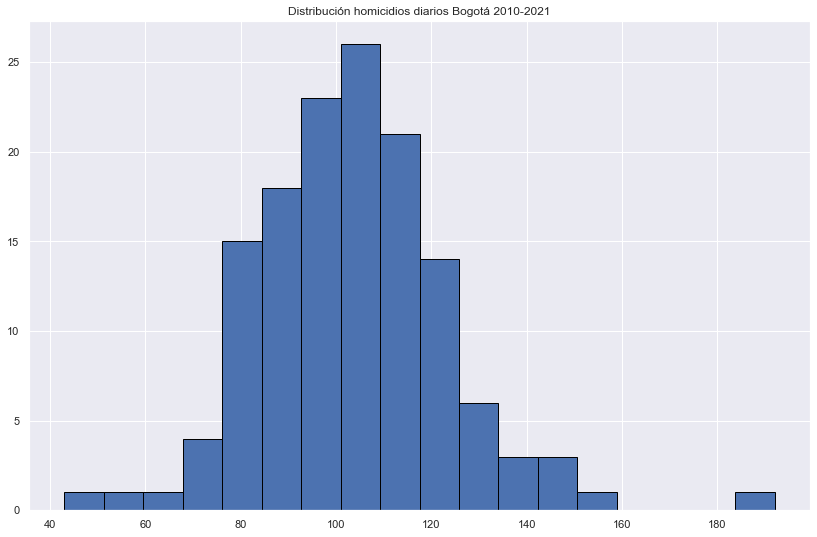

<Figure size 1008x648 with 0 Axes>

In [64]:
#Con la serie transformada es importante revisar si la distribución es "normal"

plt.title('Distribución homicidios diarios Bogotá 2010-2021')
plt.hist(tstrend, bins=18, alpha=1, edgecolor = 'black',  linewidth=1)
plt.grid(True)
plt.show()
plt.clf()

# Se aprecia en el histograma una distribución normal con asimétrica positiva

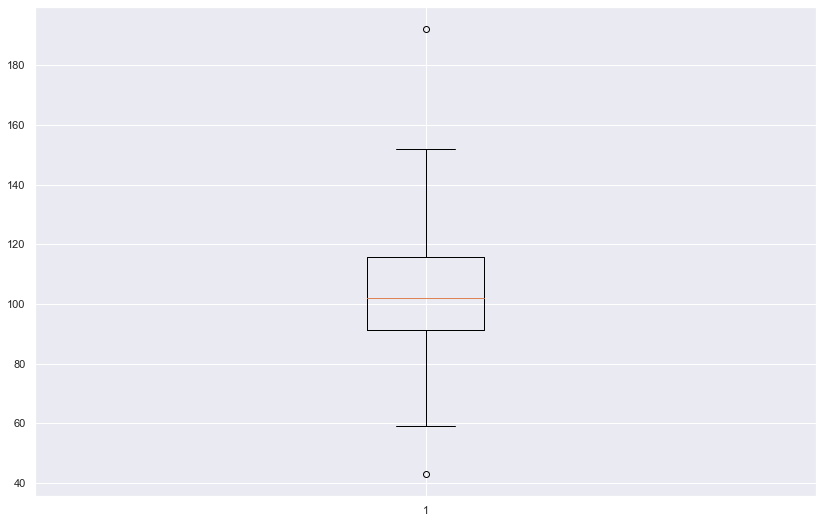

In [161]:
#Revisar datos atípicos con box-plot
#Se observa que hay dos outliers, uno corresponde a 192 hocimidios en el año 2011 y 43 hocimidios en abril de 2020

plt.boxplot(tstrend)
plt.show()

# Prueba de estacionariedad - Test Dickey Fuller


Para probar la estacionariedad se utiliza el test de estacionariedad de Dickey Fuller.
Stationary: para identificar si la media y varianza son constantes

* Ho: la serie NO es estacionaria. 

Si p-value <0.05 rechazo Ho.  
Si p-value >0.05 no rechazo Ho, se sugiere que la serie tiene una raíz unitaria; es decir, No es estacionaria.  

Para este caso p-value = 0.3187 > 0.05, por lo cual no hay suficiente evidencia estadística para rechazar Ho; es decir, la serie NO es estacionaria.  

In [66]:
from statsmodels.tsa.stattools import adfuller

In [162]:
result = adfuller(tstrend.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.928648
p-value: 0.318707
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579


Debido a que la serie original mensual no es estacionaria, vamos a aplicarle la primera difercia para pobrar si con un regazo, la serie cumple con el supuesto de estacionariedad.

A la serie resultante de la primera diferencia, se le realiza el test de Dickey Fuller; obteniendo como resultado un p-value de 0.000077, con lo cual se rechaza Ho:no estacionariedad; es decir, la serie diferenciada sí es estacionaria

In [163]:
#Diferenciar la serie con un lag (rezago)
diff=(tstrend.diff().iloc[1:])

In [164]:
#Prueba Dickey Fuller para estacionariedad
result = adfuller(tstrend.diff().iloc[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -4.719056
p-value: 0.000077
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579


# Tendencia de la serie #

Para determinar la tendencia, utilizamos "moving average" (rolling) Se aprecia que los primeros años tiene una tendencia ascendente, alcanzando su máximo en el año 2011.  Posteriormente, desciende significativamente en el año 2012 y se estabiliza hasta 2016; finalmente, se observa una tendencia a la baja de forma moderada.

Algunos expertos consideran que el liderazgo del Alcalde de Bogotá es un factor prepondernate debido a sus política de seguridad y sus relaciones armónica con la Policia, la Fiscalia,la Rama Judicial y el poder ejecutivo.  

Para la época del 2011, el gobernante era Samuel Moreno Rojas, donde se evidenció poca relación con el Gobierno Nacional y adicionalmente su alcaldía fue empañada por los escándalos del carrusel de la contratación.

A partir del año 2012, asume la Alcaldía Gustavo Petro y tras retomar las acciones de administraciones anteriores, como estrechar lazos con la Policia y Fiscalia, ejecutó acciones de prevención y potenció procesos organizativos en zonas tradicionalmente violentas, lo que generó una disminución significativa en los homicidios.

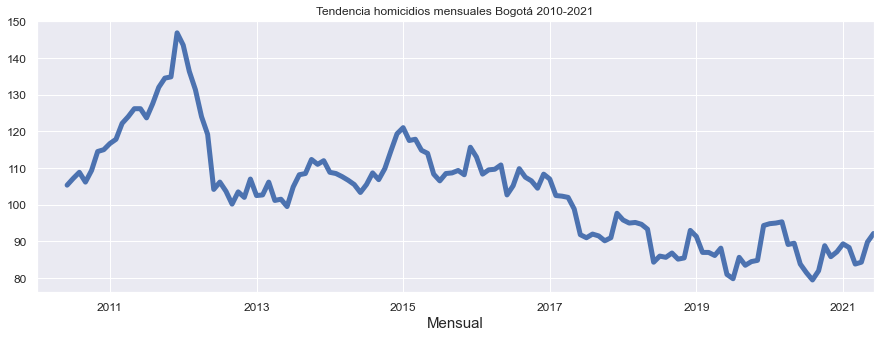

In [70]:
tstrend.rolling(6).mean().plot(figsize=(15,5), linewidth=5, fontsize=12)
plt.xlabel('Mensual', fontsize=15)
plt.title('Tendencia homicidios mensuales Bogotá 2010-2021');

# Tendencia, estacionalidad, ciclos y residuos

SEASONAL DECOMPOSE (paquete pandas):

Esta función descompone la variable objeto de estudio en sus componentes de tendencia, estacionalidad (ajustándola a un periodo de tiempo) y calculan los residuos correspondientes.
 
La tendencia se analizó en el punto anterior.

Respecto a la estacionalidad, se encuentra un patrón anual. consistente en que en el mes de diciembre de cada año, se presenta el mayor número de hocimidios y en enero desciende drásticamente; en mayo se presenta el segundo pico y coincide con la celebración del día de la madre.  Se puede intuir que estos incrementos en estas dos fechas están asociados a temas emocionales y de alcohol.  El mes con menos homicidios es febrero, lo cual podría explicarse porque no hay festividades ni festivos y a que solo tiene 28 días.

Algunas diferencias entre estacionalidad y ciclos:

	La duración del ciclo es variable –el patrón de la estacionalidad es constante
	El promedio de duración del ciclo es más largo que el patrón de estacionalidad
	Magnitud del ciclo es más variable que la de la estacionalidad
	El tiempo de los picos y caídas es predecible en la estacionalidad, pero no predecibles en el largo plazo en ciclos

De acuerdo con estos conceptos, se pueden apreciar ciclos cada dos (2) años; sin embargo, no estan claro entre 2015 a 2017.



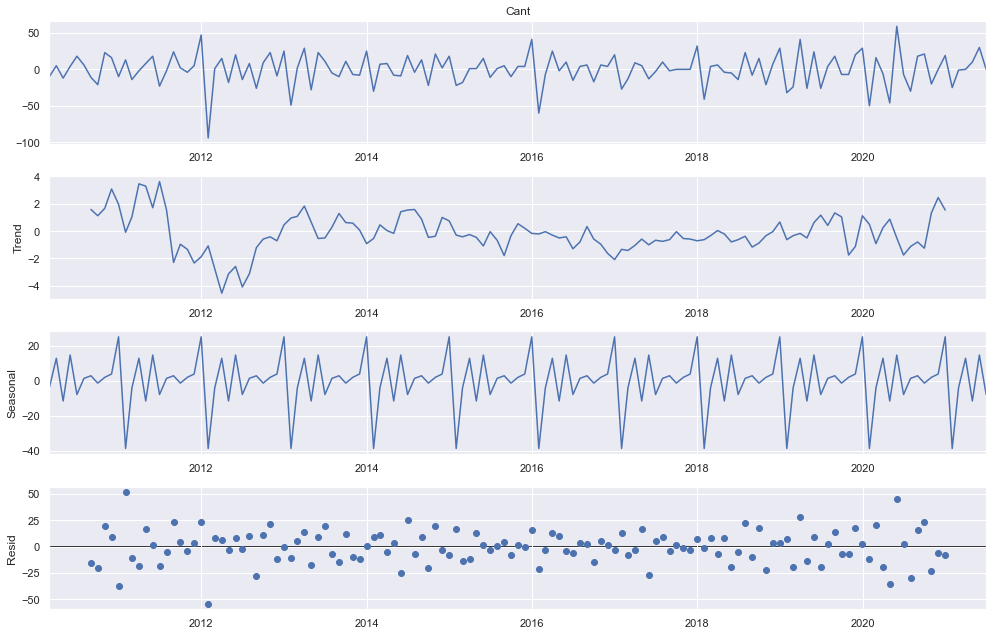

In [71]:
#descomponer la serie en trend, seasonal and residuals
result_diff=seasonal_decompose(diff, model='additive') ##Serie diferenciada
r=result_diff.plot()


<AxesSubplot:xlabel='Fecha'>

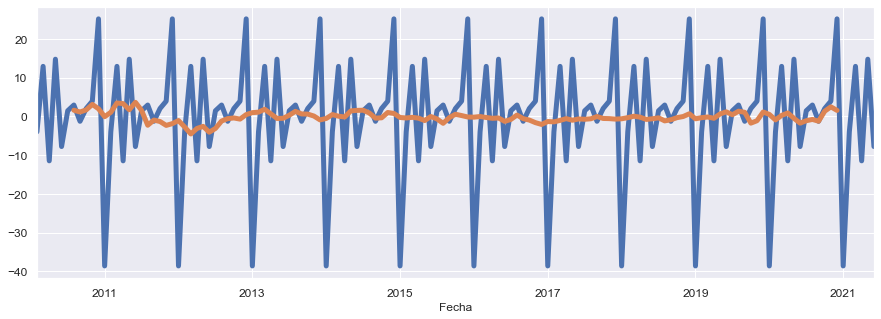

In [72]:
#Observemos los resultados en una gráfica ampliada
result_diff=seasonal_decompose(diff, model='additive') ##Serie diferenciada
result_diff.seasonal.plot(figsize=(15,5), linewidth=5, fontsize=12)
result_diff.trend.plot(figsize=(15,5), linewidth=5, fontsize=12)

<AxesSubplot:xlabel='Fecha'>

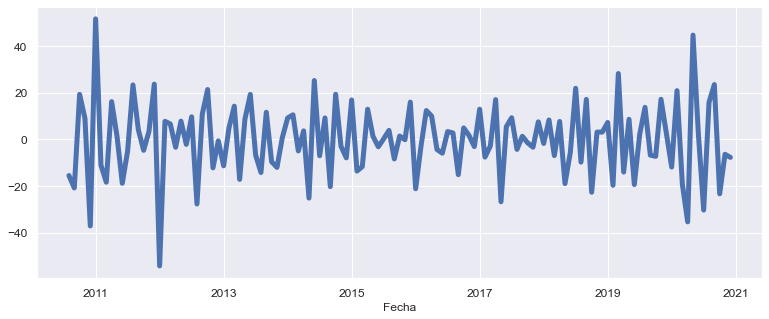

In [73]:
#Residuos
result_diff.resid.plot(figsize=(13,5), linewidth=5, fontsize=12)

#Respecto a los residuos se aprecia que tienden a ser constantes en el período analizado, tendiendo a cero.

## Análsiis de autocorrelation #

La autocorrelación se verifica sobre una serie que es estacionaria; para este caso se realiza sobre la diferenciada (diff)

En el gráfico de autocorrelación se puede sugerir que hay una caida abrupta en el período 1,12 y 24; lo cual se podría asociaciar a un modelo MA(1), MA(12)o MA(24).  Por otra parte, de manera general se podría identificar un descenso con patrón geométrico, que nos sugiere considerar un modelo AR.

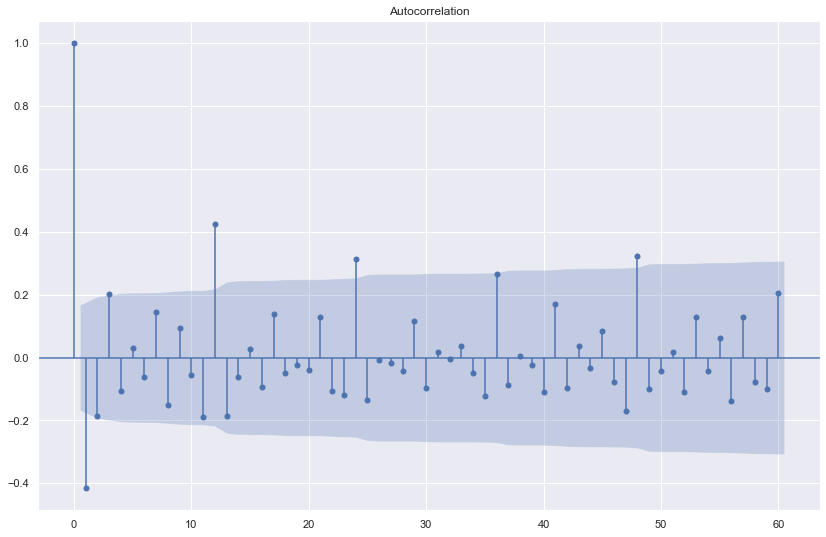

In [75]:
plot_acf(diff, lags=60);#autocorrelación sobre la serie estacionaria.

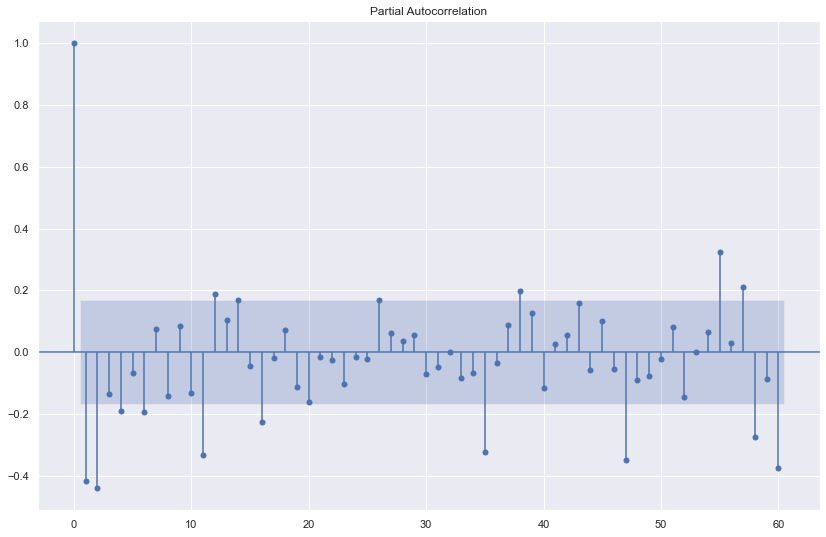

In [147]:
#Autocorrelaicón parcial
plot_pacf(diff, lags=60);

En la autocorrelación parcial, se aprecia una caida abrupta en el período 2, por lo cual se podría considerar que es un proceso AR(2).

### Establecer modelo ARIMA y parámetros

In [140]:
# A continuación vamos a realizar varias iteraciones aplicando un "for" para hallar el mejor parámetro p,d,q; teniendo 
#como métrica el menor AIC
import itertools

In [78]:
p=range(0,12)
q=range(0,12)
d=range(0,2)
pdq=list(itertools.product(p,d,q))

In [142]:
AICres = []
for param in pdq:
    try:
        model_arima=ARIMA(tstrend, order=param)
        model_arima_fit=model_arima.fit()
        AICres.append(model_arima_fit.aic)
    except:
        continue


In [79]:
# El resultado nos sugiere que los mejores parámetros para el modelo ARIMA es (10,1,10)
pdq[np.argmin(AICres)]

(10, 1, 10)

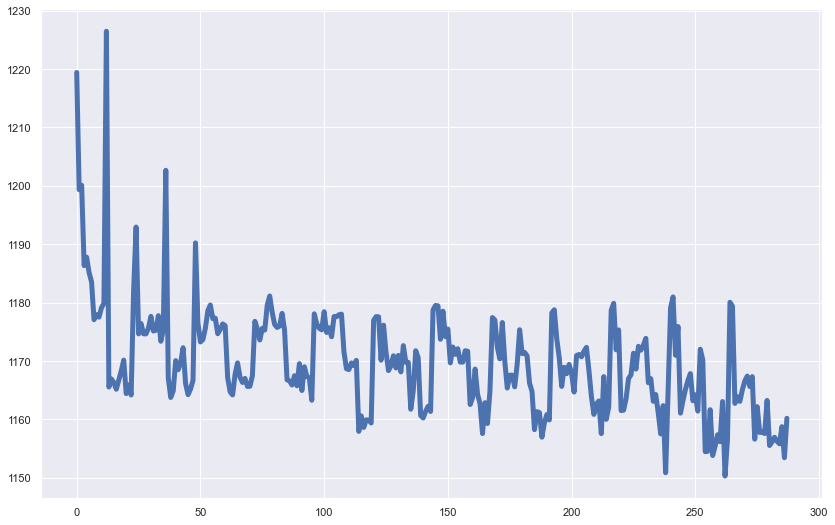

In [80]:
#Grafica los AIC de los diferentes parámetros corridos anteriormente para el modelo ARIMA
plt.plot(AICres, linewidth=5)

In [148]:
#MODELO ARIMA
model = ARIMA(tstrend, order=(pdq[np.argmin(AICres)]))
model_fit = model.fit()
print(model_fit.aic)
model = ARIMA(tstrend, order=(2,1,12))
model_fit1 = model.fit()
print(model_fit1.aic)

1150.2830702963306
1156.8047252352726


La diferencia de los AIC entre el modelo derivado de las observaciones de los gráfico ACF y PACF - ARIMA(2,1,12) y el óptimo encontrado en las iteraciones (10,1,10), por lo cual trabajaremos con el modelo sugerido (10,1,10)

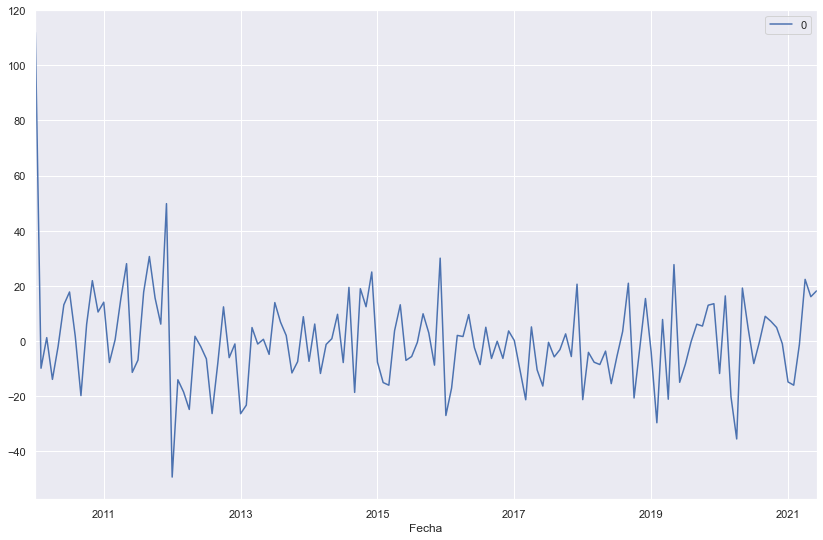

In [159]:
# Residuos del modelo
residuals = pd.DataFrame(model_fit1.resid)
residuals.plot()
plt.show()

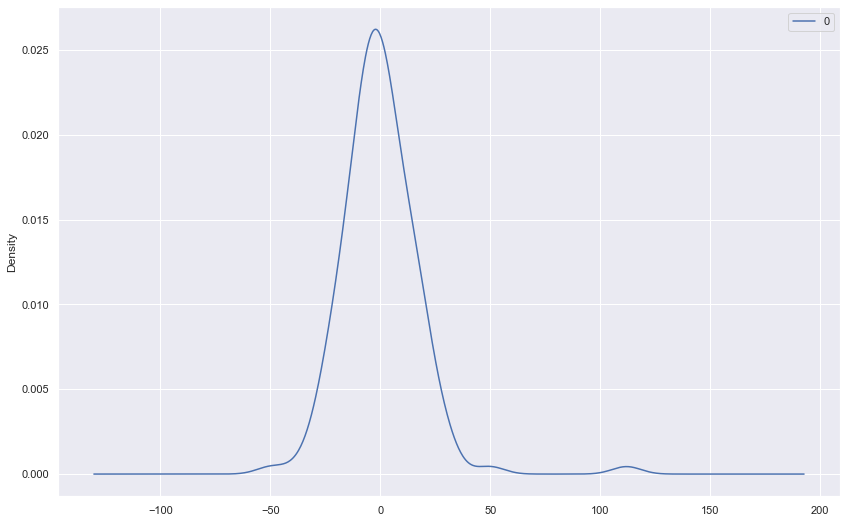

                0
count  138.000000
mean     0.038199
std     17.592178
min    -49.502770
25%     -8.660069
50%     -0.830851
75%      8.837875
max    112.000000


In [150]:
#Los residuos del moelo tienden a una distribución normal.  Cumple los supuesto de homocedastiicadad y normalidad de los residuos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### Predicciones

In [157]:
#Para realizar las predicciones se parte la base original en 80% de los datos para "train" (110 meses) y el 20%
#restante para test (28 meses).  Se entrena el modelo con los parámetros indicados anteriormente (2,1,12), y a continuación
# se valida el modelo con el set de test y se calcula el MSE (desempeño del modelo).

X = tstrend.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]#split para set de train y set de test
history = [x for x in train]
future = [x for x in test]

model = ARIMA(history, order=(10,1,10))#entrenamiento del modelo
model_fit = model.fit() #modelo ajustado
output = model_fit.forecast(steps=len(test))
yhat = output
predictions = yhat
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))

       predict  real
0    84.691786   100
1    91.683389    74
2    79.729122    98
3    73.219874    72
4    88.046846    76
5    85.090877    94
6    85.580677    87
7    75.707062    80
8    82.604930   100
9   102.008647   129
10   76.004908    79
11   68.890606    95
12   85.326009    89
13   90.505279    43
14   78.037553   102
15   74.545898    95
16   88.457970    65
17   87.316284    83
18   86.675356   104
19   72.453530    84
20   78.216017    84
21   98.726465   103
22   78.743395    78
23   70.621471    77
24   85.981680    77
25   92.668527    87
26   79.067767   117
27   74.614262   117


In [158]:
#Mean Square Error - MSE
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 376.980


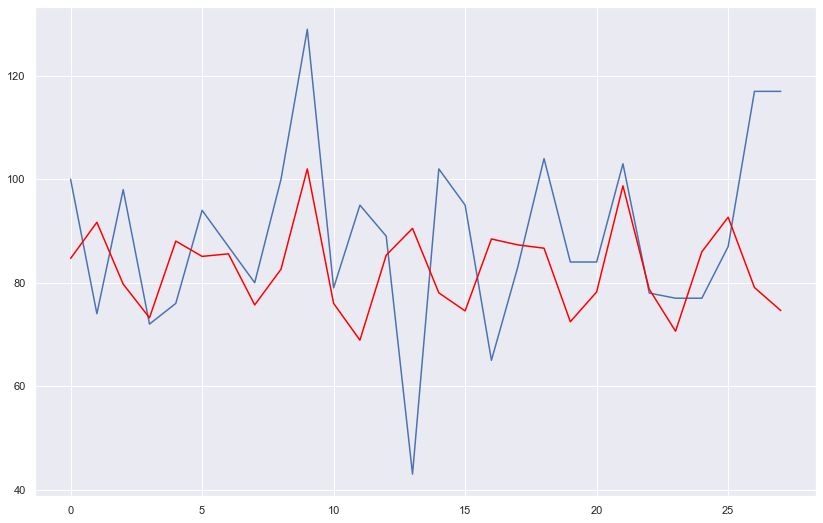

In [160]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [184]:
# Pronóstico para el mes julio de 2021
forecast = model_fit.forecast()[0]
print(forecast)

84.69178560138417


### Conclusiones

Se encontró que la serie original no es estacionaria; sin embargo, su primera diferencia sí lo es. Adicionalmente, se encontró que los meses de diciembre y mayo son los de mayores cifras de homicidios.

Realizando el análisis de los datos, se encontró que el mejor modelo ARIMA para realizar las predicciones tiene los parámetros (10,1,10): AR(10), diferencia=1, MA(10); estos parámetros corresponden al menor AIC encontrado.